# Bayesian Probabilistic Matrix Factorization using MCMC

In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch
from scipy.stats import wishart
import numpy as np
import matplotlib.pyplot as plt
d = 5

## Load data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 1000209
num users: 6041, num items: 3707


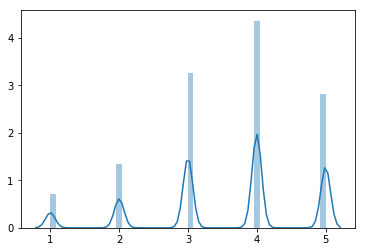

In [39]:
ds = get_movielens_dataset(variant='1M')

items = pd.read_csv("movies.dat", delimiter="::", header=None, engine = "python")
items.columns = ['itemId', 'name','genre']
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")




## Explicit Matrix Factorization
Train an explicit model to kickstart the mcmc optimization.
Using spotlight's explicit mf model to do so. The BilinearNet is a modification from the original with no bias.

In [3]:
import torch.nn as nn

from spotlight.layers import ScaledEmbedding, ZeroEmbedding


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 user_embedding_layer=None, item_embedding_layer=None, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        if user_embedding_layer is not None:
            self.user_embeddings = user_embedding_layer
        else:
            self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                                   sparse=sparse)

        if item_embedding_layer is not None:
            self.item_embeddings = item_embedding_layer
        else:
            self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                   sparse=sparse)

        #self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        #self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        #user_bias = self.user_biases(user_ids).squeeze()
        #item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot #+ user_bias + item_bias

In [4]:
network = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)

model = ExplicitFactorizationModel(n_iter=1, embedding_dim=d, representation=network)


In [5]:
%%time
for t in range(20):
    model.fit(train)
    rmse_test = rmse_score(model, test)
    rmse_train = rmse_score(model, train)
    print(f'step: {t} \t rmse train: {rmse_train:.2f}, test: {rmse_test:.2f}')

step: 0 	 rmse train: 0.95, test: 0.97
step: 1 	 rmse train: 0.92, test: 0.95
step: 2 	 rmse train: 0.90, test: 0.94
step: 3 	 rmse train: 0.89, test: 0.93
step: 4 	 rmse train: 0.88, test: 0.93
step: 5 	 rmse train: 0.88, test: 0.93
step: 6 	 rmse train: 0.88, test: 0.93
step: 7 	 rmse train: 0.88, test: 0.93
step: 8 	 rmse train: 0.87, test: 0.92
step: 9 	 rmse train: 0.87, test: 0.92
step: 10 	 rmse train: 0.87, test: 0.93
step: 11 	 rmse train: 0.87, test: 0.92
step: 12 	 rmse train: 0.87, test: 0.92
step: 13 	 rmse train: 0.87, test: 0.92
step: 14 	 rmse train: 0.87, test: 0.92
step: 15 	 rmse train: 0.87, test: 0.92
step: 16 	 rmse train: 0.87, test: 0.92
step: 17 	 rmse train: 0.86, test: 0.92
step: 18 	 rmse train: 0.86, test: 0.92
step: 19 	 rmse train: 0.86, test: 0.92
CPU times: user 1min 39s, sys: 1.58 s, total: 1min 41s
Wall time: 1min 44s


## Bayesian mf MCMC

In [6]:
from torch.distributions import MultivariateNormal as MNorm
import torch.nn as nn
class BayesianMF(nn.Module):
    def __init__(self, train, 
                 test,
                 num_users, 
                 num_items,
                 embedding_dim,
                 alpha = 2,
                 beta0 = 2
                ):
        
        super(BayesianMF, self).__init__()
        self.train = train
        if test:
            self.test = test
        self.num_items = num_items
        self.num_users = num_users
        self.embedding_dim = embedding_dim
        self.alpha = alpha
        self.beta0 = beta0
        self.mu0 = torch.zeros(embedding_dim).view(-1,1) # defined in 3.1. think this actually is a vector, but can be treated as scalar due to broadcasting
        self.W0_inv = torch.eye(embedding_dim).inverse() # defined in 3.1
        
        self.U = torch.zeros(self.num_users, self.embedding_dim) # torch.randn((ds.num_users,d))
        self.V = torch.zeros(self.num_items, self.embedding_dim) #torch.randn((ds.num_items,d))
        
    def sample_hyperparam(self, M):
        K = M.size()[0] #  NUM_USERS/NUM_ITEMS
        df0_star = self.embedding_dim + K # eq 14
        beta0_star = self.beta0 + K # eq 14
        M_avg = M.mean(0).view(-1,1)
        mu0_star = (beta0_star*self.mu0 + K * M_avg) / (beta0_star) # eq 14
        mu0_star = mu0_star.double().view(-1)

        S_avg = M.transpose(0,1).mm(M)/K # eq 14

        W0_star_inv =  self.W0_inv + K*S_avg + self.beta0*K/(beta0_star) * ((self.mu0-M_avg) * (self.mu0 - M_avg).transpose(0,1)) # eq 14
        W0_star = W0_star_inv.inverse()

        lambda_M = wishart.rvs(df = df0_star, scale = W0_star)
        lambda_M = torch.tensor(lambda_M).double()
        #print(mu0_star[:2])

        covar = (lambda_M*beta0_star).inverse()

        mulvarNormal = MNorm(mu0_star, covariance_matrix=covar)


        mu_M = mulvarNormal.sample()
        return mu_M.float().view(-1,1), lambda_M.float()

    
    def get_vector_params(self, idx, mode, mu_K, lambda_K):
        if mode == "user":
            O = self.V
            data_idx = self.train.user_ids==idx
            vec = self.U[idx]
            other_obj = self.train.item_ids[data_idx]
        if mode == "item":
            O = self.U
            data_idx = self.train.item_ids==idx
            vec = self.V[idx]
            other_obj = self.train.user_ids[data_idx]

        Oj = O[other_obj,]
        r = self.train.ratings[data_idx]
        r = torch.tensor(r).view(-1,1)
        
        if len(r) == 0: # if no data return hyperparameters
            return mu_K, lambda_K
        ratings_for_idx = (vec * Oj).sum(1)

        # Calc lambda i star (eq 12)
        lambda_istar =  lambda_K + self.alpha*(Oj.transpose(0,1).mm(Oj))
        covar = lambda_istar.inverse()

        # Calc mu i star (eq 13)
        scoresum = self.alpha*(Oj*r).sum(0).view(-1,1)
        mu_istar = covar.mm(scoresum + lambda_K.mm(mu_K))
        return mu_istar, lambda_istar

    def sample_useritem_vector(self, idx, mode, mu_K, lambda_K):
        mu, prec = self.get_vector_params(idx, mode, mu_K, lambda_K)
        mulvarNormal = MNorm(mu.view(-1), precision_matrix=prec)
        return mulvarNormal.sample()
    
    def step_mcmc(self):
        mu_v, lambda_v = self.sample_hyperparam(self.V)
        mu_u, lambda_u = self.sample_hyperparam(self.U)
        
        for idx in range(self.num_users):
            self.U[idx,] = self.sample_useritem_vector(idx, "user", mu_u, lambda_u)
            
        for idx in range(self.num_items):
            self.V[idx,] = self.sample_useritem_vector(idx, "item", mu_v, lambda_v)
            
    def posterior_given_object(self, idx, mode):
        if mode == "user":
            mu_u, lambda_u = self.sample_hyperparam(self.U)
            return self.sample_useritem_vector(idx, "user", mu_u, lambda_u)
        if mode == "item":
            mu_v, lambda_v = self.sample_hyperparam(self.V)
            return self.sample_useritem_vector(idx, "item", mu_v, lambda_v)
        
    def posterior_score(self, userId, itemId, samples = 500):
        uservecs = torch.zeros((samples,self.embedding_dim))
        itemvecs = torch.zeros((samples,self.embedding_dim))
        
        for k in range(samples):
            uservecs[k] = self.posterior_given_object(userId, "user")
            itemvecs[k] = self.posterior_given_object(itemId, "item")
            
        scores = (uservecs*itemvecs).sum(1)
        return scores, uservecs, itemvecs
        
    def predict(self, user_ids, item_ids):
        uservec = self.U[user_ids]
        itemvec = self.V[item_ids]
        return (uservec * itemvec).sum(1)
    
    def fit(self, num_epochs, report_int=1):
        for t in range(num_epochs):
            self.step_mcmc()
                
            ## REPORTING ###
            if t%report_int == 0:
                rmse_train = rmse_score(self, self.train)
                rmse_test = rmse_score(self, self.test)
                print(f'step: {t} \t rmse train: {rmse_train:.2f}, test: {rmse_test:.2f}')
    
bayesmodel = BayesianMF(train=train, 
                        test = test,
                        num_items=ds.num_items,
                        num_users = ds.num_users,
                        embedding_dim = d)

bayesmodel

BayesianMF()

In [7]:
%%time
bayesmodel.fit(20)

step: 0 	 rmse train: 3.75, test: 3.75
step: 1 	 rmse train: 3.75, test: 3.75
step: 2 	 rmse train: 3.75, test: 3.75
step: 3 	 rmse train: 3.75, test: 3.75
step: 4 	 rmse train: 3.19, test: 3.20
step: 5 	 rmse train: 0.98, test: 1.00
step: 6 	 rmse train: 0.91, test: 0.92
step: 7 	 rmse train: 0.90, test: 0.92
step: 8 	 rmse train: 0.90, test: 0.92
step: 9 	 rmse train: 0.90, test: 0.92
step: 10 	 rmse train: 0.90, test: 0.92
step: 11 	 rmse train: 0.90, test: 0.92
step: 12 	 rmse train: 0.90, test: 0.92
step: 13 	 rmse train: 0.90, test: 0.92
step: 14 	 rmse train: 0.90, test: 0.92
step: 15 	 rmse train: 0.90, test: 0.92
step: 16 	 rmse train: 0.90, test: 0.92
step: 17 	 rmse train: 0.90, test: 0.92
step: 18 	 rmse train: 0.90, test: 0.92
step: 19 	 rmse train: 0.90, test: 0.92
CPU times: user 2min 58s, sys: 6.79 s, total: 3min 5s
Wall time: 3min 5s


## Analysis

### Distribution of some random user item combinations

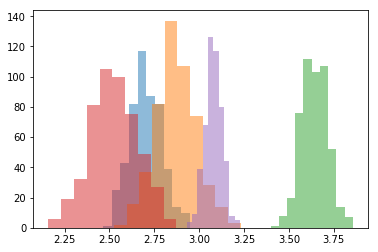

In [8]:
users = np.random.randint(low=0,high=bayesmodel.num_users, size = 5)
items = np.random.randint(0,bayesmodel.num_items, size = 5)
for u,i in zip(users,items):
    score, uvec, ivec = bayesmodel.posterior_score(userId=u, itemId=i)
    _ = plt.hist(score.numpy(), alpha = 0.5)

## Posterior score distribution in user item pairs with with lots of data vs little data
Guess which distribution is from what pair...

least pop item: 1806
most pop item: 105
least pop users: 3897
most pop users: 4169


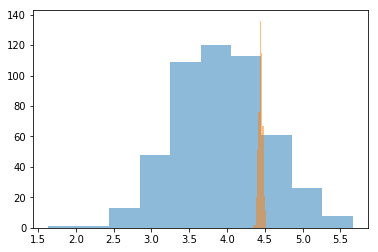

In [9]:
items, counts = np.unique(train.item_ids, return_counts=True)
item_min = items[counts == counts.min()][0]
item_max = items[counts == counts.max()][0]
print("least pop item: {}".format(item_min))
print("most pop item: {}".format(item_max))

users, counts = np.unique(train.user_ids, return_counts=True)
user_min = users[counts == counts.min()][0]
user_max = users[counts == counts.max()][0]
print("least pop users: {}".format(user_min))
print("most pop users: {}".format(user_max))

score, uvec, ivec = bayesmodel.posterior_score(userId=user_min, itemId=item_min)
_ = plt.hist(score.numpy(), alpha = 0.5)

score, uvec, ivec = bayesmodel.posterior_score(userId=user_max, itemId=item_max)
_ = plt.hist(score.numpy(), alpha = 0.5)

#### Posterior vectors from least and most active objects
Plot of posterior user and item vectors for the user item pairs with most and least data (guess which is which).

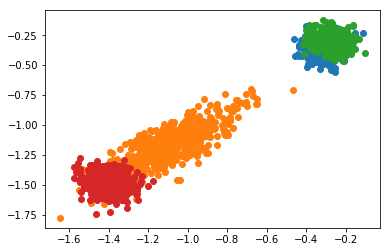

In [10]:
score, uvec, ivec = bayesmodel.posterior_score(userId=user_min, itemId=item_min)
uvec, ivec = uvec.numpy(), ivec.numpy()
_ = plt.plot(uvec[:,0], uvec[:,1], "o")
_ = plt.plot(ivec[:,0], ivec[:,1], "o")
score, uvec, ivec = bayesmodel.posterior_score(userId=user_max, itemId=item_max)
uvec, ivec = uvec.numpy(), ivec.numpy()
_ = plt.plot(uvec[:,0], uvec[:,1], "o")
_ = plt.plot(ivec[:,0], ivec[:,1], "o")

## Variations in topK predictions
Given two different users (the maximum and minimum user), how does their recommendations spread qualitatively?
For each user we sample five different posteriors and fetch top 5 movies for each posterior sample.

In [76]:
u = user_max
for k in range(5):
    bayesmodel.step_mcmc()
    preds = bayesmodel.predict(u,torch.arange(0,bayesmodel.num_items))
    scores, sorts = preds.sort(descending=True)
    print(" \t | ".join([ ind2item[int(i)] for i in sorts[:5]]))

Outlaw Josey Wales, The (1976) 	 | Volunteers (1985) 	 | In Old California (1942) 	 | Blood Spattered Bride, The (La Novia Ensangrentada) (1972) 	 | Joe Gould's Secret (2000)
Marathon Man (1976) 	 | Man Bites Dog (C'est arriv� pr�s de chez vous) (1992) 	 | Shanghai Noon (2000) 	 | Wirey Spindell (1999) 	 | Running Man, The (1987)
White Christmas (1954) 	 | Light Years (1988) 	 | Joe Gould's Secret (2000) 	 | Pandora and the Flying Dutchman (1951) 	 | Freedom for Us (� nous la libert� ) (1931)
Outlaw Josey Wales, The (1976) 	 | Night Visitor, The (1970) 	 | Last September, The (1999) 	 | Moonraker (1979) 	 | Hellhounds on My Trail (1999)
Airplane! (1980) 	 | Quatermass and the Pit (1967) 	 | Volunteers (1985) 	 | Keeping the Faith (2000) 	 | Man Bites Dog (C'est arriv� pr�s de chez vous) (1992)


In [77]:
u = user_min
for k in range(5):
    bayesmodel.step_mcmc()
    preds = bayesmodel.predict(u,torch.arange(0,bayesmodel.num_items))
    scores, sorts = preds.sort(descending=True)
    print(" \t | ".join([ ind2item[int(i)] for i in sorts[:5]]))

Moonraker (1979) 	 | Hamlet (2000) 	 | Anna and the King (1999) 	 | Porky's (1981) 	 | <UNK>
Porky's (1981) 	 | White Christmas (1954) 	 | Pandora and the Flying Dutchman (1951) 	 | Anna and the King (1999) 	 | Dying Young (1991)
Blood Spattered Bride, The (La Novia Ensangrentada) (1972) 	 | Hellhounds on My Trail (1999) 	 | Seven Days in May (1964) 	 | Running Man, The (1987) 	 | Last Picture Show, The (1971)
Brother from Another Planet, The (1984) 	 | Blow-Out (La Grande Bouffe) (1973) 	 | Porky's (1981) 	 | Quatermass and the Pit (1967) 	 | Running Man, The (1987)
Running Man, The (1987) 	 | Hamlet (2000) 	 | Where the Heart Is (2000) 	 | Marathon Man (1976) 	 | Cool as Ice (1991)
